__Автор__: Карпаев Алексей, ассистент кафедры информатики и вычислительной математики.

# Объектно-ориентированная реализация численного решения обыкновенных дифференциальных уравнений

Сначала рассмотрим процедурный код, который мы бы стали писать, если бы потребовалось наскоро найти численное решение тривиальной задачи Коши для автономного скалярного уравнения

$$ \frac{d u}{d t} = f\left(u \right) $$
$$ u \left( 0 \right) = u_0 $$
$$ 0 \leq t \leq T $$

В качестве тестового примера будем рассматривать __логистическое уравнение__, описывающее динамику популяции с учетом  влияния различных факторов окружающей среды, ограничивающих экспоненциальный рост населения со временем (эмпирический факт):

$$ \frac{d u}{d t} = \alpha \cdot u \left(1 - \frac{u}{R}\right) $$
$$ u \left( 0 \right) = u_0 $$
$$ 0 \leq t \leq T $$

Для проведения численного интегрирования уравнения на отрезке $0 \leq t \leq T$ вводим равномерную сетку:

$$
    G_{\Delta t} = \{ t_i: t_i = i \Delta t; i = 0,...,N; \Delta t = \frac{T}{N} \}
$$

Примеры реализации методов численного решения ОДУ, написанных в процедурном стиле:

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def LogisticRightHandSide(u):
    return 0.2*u*(1 - u)

def PlotSolution(timeArray, solutionArray, title):
    plt.figure()
    plt.plot(timeArray, solutionArray, '-', linewidth=4, markersize = 10)
    plt.grid('on')
    plt.title(title)
    plt.xlabel('t, s')
    plt.ylabel('Normalized population')
    plt.show()

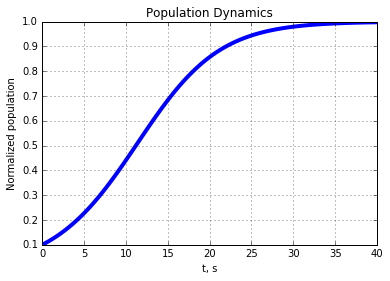

In [12]:
def SolveODEExplicitEuler(function, tEnd, numBlocks, initialValue):
    dt = float(tEnd)/float(numBlocks)
    timeArray = np.linspace(0, tEnd, numBlocks + 1)
    solutionArray = np.zeros(numBlocks + 1)
    
    solutionArray[0] = initialValue
    for i in range(numBlocks):
        solutionArray[i + 1] = solutionArray[i] + dt*function(solutionArray[i])
    return timeArray, solutionArray


timeArrayEE, solutionArrayEE = SolveODEExplicitEuler(LogisticRightHandSide, 40., 100, 0.1)
PlotSolution(timeArrayEE, solutionArrayEE, 'Population Dynamics')

Реализация метода Рунге-Кутты 2-го порядка точности (модифицированный метод Эйлера с пересчетом):

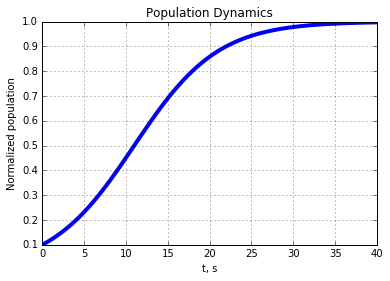

In [13]:
def SolveODEModifiedEuler(function, tEnd, numBlocks, initialValue):
    dt = float(tEnd)/float(numBlocks)
    timeArray = np.linspace(0, tEnd, numBlocks+1)
    solutionArray = np.zeros(numBlocks+1)
    
    solutionArray[0] = initialValue
    for i in range(numBlocks):
        uStar = solutionArray[i] + dt*function(solutionArray[i])
        solutionArray[i + 1] = solutionArray[i] + dt/2. \
                            * (function(solutionArray[i]) + function(uStar))
    
    return timeArray, solutionArray

                            
# main
timeArrayME, solutionArrayME = SolveODEModifiedEuler(LogisticRightHandSide, 40., 100, 0.1)
PlotSolution(timeArrayME, solutionArrayME, 'Population Dynamics')

C0 norm error = 9.98e-03
L2 norm error = 2.31e-01


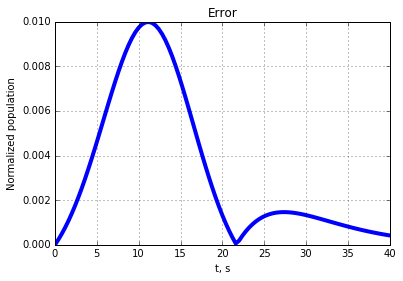

In [14]:
# вывод погрешности на экран
pointwiseError = np.array(solutionArrayEE) - np.array(solutionArrayME)
print 'C0 norm error = %.2e' % np.amax(np.fabs(pointwiseError))
print 'L2 norm error = %.2e' % (np.sqrt(np.sum(np.abs(pointwiseError)[:-1])) * 40./100)

PlotSolution(timeArrayEE, np.fabs(pointwiseError), 'Error')

Метод Рунге-Кутты 4-го порядка точности:

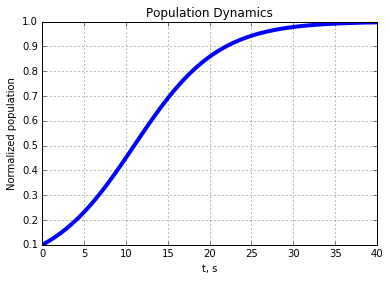

In [15]:
def SolveODERungeKutta4(function, tEnd, numBlocks, initialValue):
    dt = float(tEnd)/float(numBlocks)
    timeArray = np.linspace(0, tEnd, numBlocks+1)
    solutionArray = np.zeros(numBlocks+1)
    
    solutionArray[0] = initialValue
    
    # для краткости; переприсвоение переменных-ссылок следует использовать только для чтения данных
    f, t, u, n = function, timeArray, solutionArray, numBlocks
    
    for i in range(n):
        k1 = f(u[i])
        k2 = f(u[i] + dt / 2. * k1)
        k3 = f(u[i] + dt / 2. * k2)
        k4 = f(u[i] + dt * k3)
        
        u[i + 1] = u[i] + dt / 6. * (k1 + 2. * k2 + 2. * k3 + k4)    
    
    return timeArray, solutionArray

# main
timeArrayRK4, solutionArrayRK4 = SolveODERungeKutta4(LogisticRightHandSide, 40., 100, 0.1)
PlotSolution(timeArrayRK4, solutionArrayRK4, 'Population Dynamics')

В вышеприведенных функциях численного решения ОДУ присутствует сравнительно небольшое количество строк, и их написание занимает пару минут - подходит для быстрого получения результатов. Однако, если нам требуется провести детальный анализ численного решения с учетом применения различных методов численного интегрирования ОДУ или программа создается для многократного использования в т.ч. и сторонними пользователями/разработчиками, то использование объектно-ориентированного стиля является более предпочтительным.

Из вышеприведенных реализаций видно, что в коде присутствуют дословно повторяющиеся участки, т.е. перед нами опять возникла задача сокращения размера программы, которую поможет решить применение классов и механизмов наследования.

__Для начала__ сконструируем класс, в котором реализуем функционал, требующийся для реализации вычислений по модифицированному методу Эйлера (class __ModifiedEuler__). Какой минимальный набор полей и методов требуется для этого? (назовите):

__Поля класса__:
* функция правой части ОДУ
* начальное условие
* множество точек сетки и ее параметры: кол-во точек, промежутков, шаг сетки
* начальный и конечный моменты времени
* номер текущего шага по времени (необязательно)

__Методы класса__:
* Конструктор
* Задать начальные условия
* Задать функцию правой части
* Решить ОДУ (таймстеппинг - цикл по точкам сетки)
* Построить график численного решения (необязательно)

In [16]:
# оформление функции правой части в виде функтора
class LogisticRightHandSide:
    def __init__(self):
        pass
        
    def __call__(self, u):
        return 0.2*u*(1 - u)

In [17]:
import time

class ModifiedEuler_version1:
    def __init__(self):
        print 'A %s solver initialized.' % self.__class__.__name__
        
    def SetRightHandSide(self, function):
        self._rightHandSideFunction = function
    
    def SetInitialCondition(self, value):
        self._initialValue = value
       
    def SetGrid(self, numBlocks, tStart, tEnd):
        self._numBlocks, self._numPoints = numBlocks, numBlocks + 1
        self._dt = float(tEnd)/float(self._numBlocks)
        self._solutionArray = np.zeros(self._numPoints)
        self._timeArray = np.linspace(tStart, tEnd, self._numPoints)
        self._tStart, self._tEnd = tStart, tEnd
        
        # вспомогательная переменная, используется для вывода прогресса решения на экран
        self._isLessThanloo = True
        if self._numBlocks > 100:
            self._isLessThanloo = False
        
        
    def GetStepNumber(self):
        return self._counter
        
    
    def Solve(self):
        """Calculates numerical solution for 0 <= t <= T.""" 
        start = time.clock()
        self._counter = 0
        
        print 'Start of timestepping via %s method...' % self.__class__.__name__
        self._solutionArray[0] = self._initialValue
        for i in range(self._numBlocks):
            
            # для краткости
            uOld, dt, f, t = self._solutionArray[self._counter], self._dt, \
                             self._rightHandSideFunction, self._timeArray
                                
            # шаг модифицированного метода Эйлера
            uStar = uOld + dt*f(uOld)
            uNew = uOld + dt/2.*(f(uOld) + f(uStar))
            
            self._solutionArray[i + 1] = uNew
            self._counter += 1
            
            # каждые 100 шагов - вывод на экран
            if self._isLessThanloo or (self._counter % (self._numBlocks//100) == 0):
                print 'Step #%d completed.' % (self._counter)
            
        end = float(time.clock() - start)
        print 'Timestepping complete; calculations took %.2e s.' % end
    
        return self._solutionArray, self._timeArray
    
    
    def PlotSolution(self):
        plt.figure()
        plt.plot(self._timeArray, self._solutionArray, '-', linewidth=4)
        plt.grid('on')
        plt.title('Solution via %s method' % self.__class__.__name__)
        plt.xlabel('t, s')
        plt.ylabel('Normalized population')
        plt.show()

Функцию рассчета численного решения на неявном слое по времени желательно оформить как отдельный метод класса __AdvanceNextStep()__:

In [18]:
class ModifiedEuler_version2:
    def __init__(self):
        print 'A %s solver initialized.' % self.__class__.__name__
        
    def SetRightHandSide(self, function):
        self._rightHandSideFunction = function
    
    def SetInitialCondition(self, value):
        self._initialValue = value
       
    def SetGrid(self, numBlocks, tStart, tEnd):
        self._numBlocks, self._numPoints = numBlocks, numBlocks + 1
        self._dt = float(tEnd)/float(self._numBlocks)
        self._solutionArray = np.zeros(self._numPoints)
        self._timeArray = np.linspace(tStart, tEnd, self._numPoints)
        self._tStart, self._tEnd = tStart, tEnd
        
        # вспомогательная переменная для вывода на экран
        self._isLessThanloo = True
        if self._numBlocks > 100:
            self._isLessThanloo = False
        
        
    def GetStepNumber(self):
        return self._counter
    
    
    def AdvanceNextStep(self):
        """Calculates solution value at a new timelayer via Modified Euler method formula."""    
        
        # для краткости
        uOld, dt, f, i, t = self._solutionArray[self._counter], self._dt, \
                                self._rightHandSideFunction, self.GetStepNumber(), self._timeArray
                                
        # шаг модифицированного метода Эйлера
        uStar = uOld + dt*f(uOld)
        uNew = uOld + dt/2. * (f(uOld) + f(uStar))
        
        return uNew
        
    
    def Solve(self):
        """Calculates numerical solution for 0 <= t <= T.""" 
        start = time.clock()
        self._counter = 0
        
        print 'Start of timestepping via %s method...' % self.__class__.__name__
        self._solutionArray[0] = self._initialValue
        for i in range(self._numBlocks):
            self._solutionArray[i + 1] = self.AdvanceNextStep()
            self._counter += 1
            
            # каждые 100 шагов - вывод на экран для отслеживания прогресса
            if self._isLessThanloo or (self._counter % (self._numBlocks//100) == 0):
                print 'Step #%d completed.' % (self._counter)
            
        end = float(time.clock() - start)
        print 'Timestepping complete; calculations took %.2e s.' % end
        
        return self._solutionArray, self._timeArray
    
    
    def PlotSolution(self):
        plt.figure()
        plt.plot(self._timeArray, self._solutionArray, '-', linewidth=4)
        plt.grid('on')
        plt.title('Solution via %s method' % self.__class__.__name__)
        plt.xlabel('t, s')
        plt.ylabel('Normalized population')
        plt.show()

Теперь протестируем последнюю версию класса-солвера на логистическом уравнении. Говорящие имена методов класса позволяют стороннему пользователю/разработчику разобраться в коде модуля, в котором обычно запускают расчеты:

A ModifiedEuler_version1 solver initialized.
Start of timestepping via ModifiedEuler_version1 method...
Step #2 completed.
Step #4 completed.
Step #6 completed.
Step #8 completed.
Step #10 completed.
Step #12 completed.
Step #14 completed.
Step #16 completed.
Step #18 completed.
Step #20 completed.
Step #22 completed.
Step #24 completed.
Step #26 completed.
Step #28 completed.
Step #30 completed.
Step #32 completed.
Step #34 completed.
Step #36 completed.
Step #38 completed.
Step #40 completed.
Step #42 completed.
Step #44 completed.
Step #46 completed.
Step #48 completed.
Step #50 completed.
Step #52 completed.
Step #54 completed.
Step #56 completed.
Step #58 completed.
Step #60 completed.
Step #62 completed.
Step #64 completed.
Step #66 completed.
Step #68 completed.
Step #70 completed.
Step #72 completed.
Step #74 completed.
Step #76 completed.
Step #78 completed.
Step #80 completed.
Step #82 completed.
Step #84 completed.
Step #86 completed.
Step #88 completed.
Step #90 completed.


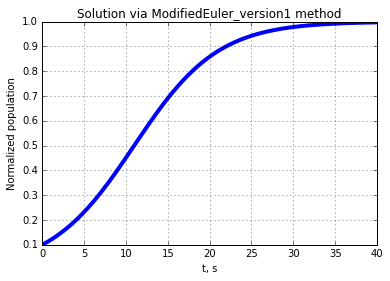

A ModifiedEuler_version2 solver initialized.
Start of timestepping via ModifiedEuler_version2 method...
Step #2 completed.
Step #4 completed.
Step #6 completed.
Step #8 completed.
Step #10 completed.
Step #12 completed.
Step #14 completed.
Step #16 completed.
Step #18 completed.
Step #20 completed.
Step #22 completed.
Step #24 completed.
Step #26 completed.
Step #28 completed.
Step #30 completed.
Step #32 completed.
Step #34 completed.
Step #36 completed.
Step #38 completed.
Step #40 completed.
Step #42 completed.
Step #44 completed.
Step #46 completed.
Step #48 completed.
Step #50 completed.
Step #52 completed.
Step #54 completed.
Step #56 completed.
Step #58 completed.
Step #60 completed.
Step #62 completed.
Step #64 completed.
Step #66 completed.
Step #68 completed.
Step #70 completed.
Step #72 completed.
Step #74 completed.
Step #76 completed.
Step #78 completed.
Step #80 completed.
Step #82 completed.
Step #84 completed.
Step #86 completed.
Step #88 completed.
Step #90 completed.


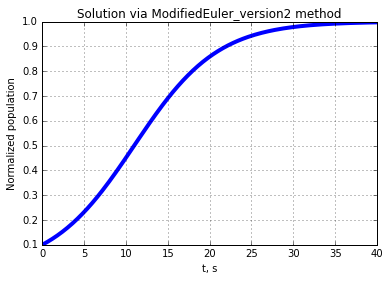

In [19]:
listOfRightHandSides = [LogisticRightHandSide()]

listOfMethods = [ModifiedEuler_version1, ModifiedEuler_version2] #  ExplicitEuler, ImplicitEuler, RungeKutta4, ...

for rightHandSide in listOfRightHandSides:
    for method in listOfMethods:
        solver = method() # создание объекта solver класса ModifiedEuler_version1
        solver.SetRightHandSide(rightHandSide)
        solver.SetInitialCondition(0.1)
        solver.SetGrid(numBlocks=200, tStart=0., tEnd=40.)
        solver.Solve()
        solver.PlotSolution()

В функции правой части также присутствуют параметры $\alpha$ и $R$. Для вычисления производной функции правой части по переменной $u$ параметры придется задать в качестве полей соответсвующего класса:

In [20]:
class LogisticRightHandSideFull:
    def __init__(self, alpha, R):
        self._alpha, self._R = float(alpha), float(R)
    
    def __call__(self, u, t):
        return self._alpha*u*(1 - u/self._R)

В случае неавтономного ОДУ с правой частью $f(u, t)$ для вычисления $\frac{\partial f}{\partial u}$ c помощью функтора __Derivative__ из Задачи 2 переменную $t$ также придется передавать в класс в качестве параметра.

## Построение иерархии классов, реализующих различные методы численного интегрирования ОДУ

В задании потребуется написать классы для одношаговых методов ч.и. ОДУ: несколько явных и 1 неявный (метод трапеций 2-го порядка точности). В родительский класс __AbstractOneStepODESolver__ поместить поля и методы класса __ModifiedEuler_version2__, свойственные всем одношаговым методам ч.и. ОДУ. Классы, реализующие остальные одношаговые методы, получить при помощи наследования.

__Критерий корректности реализации иерархии классов__: отсутствие или минимум повторяющихся строк кода.

### Реализация неявного метода трапеций
Формула для проведения вычислений:

$$ u_{n+1} = u_n + \frac{\Delta t}{2} \left( f(u_n, t_n) + f(u_{n+1}, t_{n+1}) \right), \quad n =0,...,N-1 $$ 

Для решения получившегося нелинейного уравнения относительно $u_{n+1}$ будем использовать итерационный метод Ньютона:

$$ F(u_{n+1}) \equiv  u_{n+1} - \frac{\Delta t}{2} f(u_{n+1}, t_{n+1}) - u_n - \frac{\Delta t}{2} f(u_n, t_n) = 0$$

$$ u_{n+1}^{(k+1)} = u_{n+1}^{(k)} - \frac{F( u_{n+1}^{(k)} )}{ F'(u_{n+1}^{(k)}) }, \quad u_{n+1}^{(0)} = u_n + \Delta t  f(u_n, t_n)$$

$$
k = 0,...,K \quad   \Vert u_{n+1}^{(K)} - u_{n+1}^{(K-1)} \Vert \leq \varepsilon
$$

Для ускорения сходимости начальное приближение будем рассчитывать по формуле явного метода Эйлера, а для приближенного вычисления производной будем использовать формулу центральной разности 2-го порядка точности:

$$
    F'(u_{n+1}^{(k)}) \approx \frac{F(u_{n+1}^{(k)} + h) - F(u_{n+1}^{(k)} - h)}{2h}
$$

Решение нелинейного уравнения с помощью метода Ньютона можно оформить как внутри класса, так и в виде отдельной функции. При вычислении производной задействовать функторы, реализованные в Задаче 2.